In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='1'
from tensorflow import keras
import tensorflow as tf

# gpu setting
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*4)])
    except RuntimeError as e:
        print(e)

2022-12-17 23:50:54.092116: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-12-17 23:50:55.239997: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-17 23:50:55.240864: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-17 23:50:55.284446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-12-17 23:50:55.284467: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-17 23:50:55.287273: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-17 23:50:55.287311: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-1

In [2]:
from model_DbyDeep_train import get_npy_DbyDeep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [3]:
df_test = pd.read_csv('/data/2021_SJH_detectability/data_human/test.csv')
print('Loading input peptides')
pep_test, n_test, c_test, m1_test, m2_test, label_test = get_npy_DbyDeep(df_test)

Loading input peptides


# dbydeep

In [5]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_04_False.h5")

Loading model...


2022-10-29 00:41:01.905789: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 00:41:01.908932: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-10-29 00:41:01.910625: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-10-29 00:41:01.910670: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-10-29 00:41:01.910714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

In [6]:
probs = model.predict([pep_test, n_test, c_test, m1_test, m2_test])
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate([pep_test, n_test, c_test, m1_test, m2_test], label_test)
auc = roc_auc_score(label_test, probs)

2022-10-29 00:41:08.743768: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-10-29 00:41:08.767635: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-10-29 00:41:16.331453: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-10-29 00:41:17.017560: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-10-29 00:41:17.097364: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-10-29 00:41:17.098879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


5335/5335 [==============================] - 87s 15ms/step - loss: 0.3625 - accuracy: 0.8391


Test Loss: 0.36247390508651733
Test Accuracy: 0.8390507698059082
Test AUC : 0.9192430546754715
              precision    recall  f1-score   support

       False     0.8506    0.8278    0.8390     86495
        True     0.8278    0.8506    0.8391     84211

    accuracy                         0.8391    170706
   macro avg     0.8392    0.8392    0.8391    170706
weighted avg     0.8394    0.8391    0.8391    170706



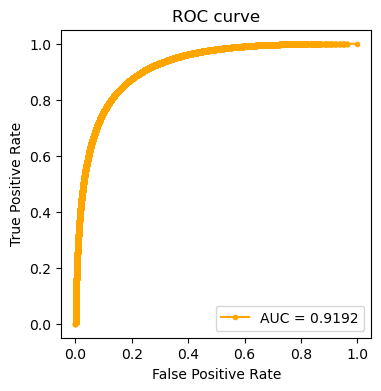

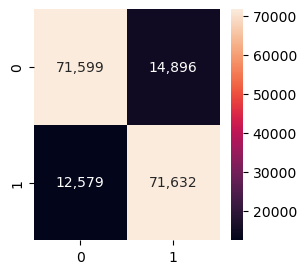

In [7]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

# Pep only

In [4]:
print('Loading model...')
model = keras.models.load_model("log/model_DbyDeep_04_True.h5")

Loading model...


2022-12-17 23:51:05.527558: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-17 23:51:05.531196: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-17 23:51:05.533214: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: NVIDIA RTX A6000 computeCapability: 8.6
coreClock: 1.8GHz coreCount: 84 deviceMemorySize: 47.54GiB deviceMemoryBandwidth: 715.34GiB/s
2022-12-17 23:51:05.533261: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-12-17 23:51:05.533319: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Succ

In [5]:
probs = model.predict(pep_test)
y_pred = [1 if i>=0.5 else 0 for i in probs]
loss, acc = model.evaluate(pep_test, label_test)
auc = roc_auc_score(label_test, probs)

2022-12-17 23:51:10.653875: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-17 23:51:10.675410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz
2022-12-17 23:51:12.130023: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-12-17 23:51:12.815328: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-12-17 23:51:12.887392: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


5335/5335 [==============================] - 17s 3ms/step - loss: 0.3779 - accuracy: 0.8299


Test Loss: 0.3779260516166687
Test Accuracy: 0.8299005031585693
Test AUC : 0.9107633013415101
              precision    recall  f1-score   support

       False     0.8367    0.8253    0.8310     86495
        True     0.8231    0.8346    0.8288     84211

    accuracy                         0.8299    170706
   macro avg     0.8299    0.8300    0.8299    170706
weighted avg     0.8300    0.8299    0.8299    170706



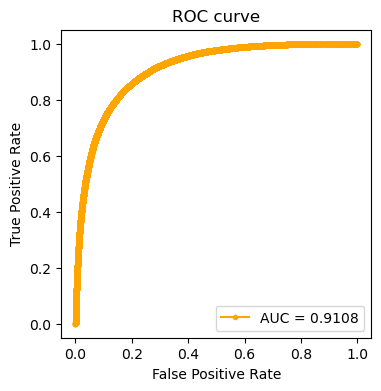

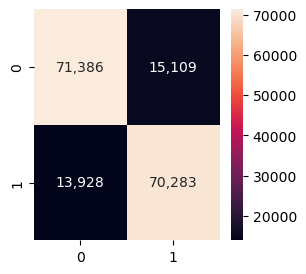

In [6]:
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))
print('Test AUC : {}'.format(auc))
print(classification_report(label_test, y_pred, digits=4))

plt.figure(figsize=(4, 4))
fpr, tpr, _ = roc_curve(label_test, probs)
plt.plot(fpr, tpr, marker='.', label='AUC = {:.4f}'.format(auc), color='orange')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

cf_matrix = confusion_matrix(label_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()

In [7]:
np.save('log/result_Ablation_fpr.npy', fpr)
np.save('log/result_Ablation_tpr.npy', tpr)